In [1]:
import os
import numpy as np
import pandas as pd
from datetime import date

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler


In [2]:
dfoff = pd.read_csv('ml100marathon-02-01/train_offline.csv')
dftest = pd.read_csv('ml100marathon-02-01/test_offline.csv')
dftest = dftest[~dftest.Coupon_id.isna()]
dftest.reset_index(drop=True, inplace=True)
print(dfoff.shape)
print(dftest.shape)
dfoff.head(20)

(1160742, 7)
(306313, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN
6,73611,2099,12034.0,100:10,NaN,20160207.0,NaN
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN


In [3]:
## Creat target label 
"""
According to the definition, 
1) buy with coupon within (include) 15 days ==> 1
2) buy with coupon but out of 15 days ==> 0
3) buy without coupon ==> -1 (we don't care)
"""
def label(row):
    if np.isnan(row['Date_received']):
        return -1
    if not np.isnan(row['Date']):
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0

dfoff["label"] = dfoff.apply(label, axis=1)
dfoff["label"].value_counts()

 0    710665
-1    413773
 1     36304
Name: label, dtype: int64

In [4]:
# Generate features - weekday acquired coupon
def getWeekday(row):
    if (np.isnan(row)) or (row==-1):
        return row
    else:
        return pd.to_datetime(row, format = "%Y%m%d").dayofweek+1 # add one to make it from 0~6 -> 1~7

dfoff['weekday'] = dfoff['Date_received'].apply(getWeekday)
dftest['weekday'] = dftest['Date_received'].apply(getWeekday)

# weekday_type (weekend = 1)
dfoff['weekday_type'] = dfoff['weekday'].apply(lambda x : 1 if x >= 6 else 0 ) # apply to trainset
dftest['weekday_type'] = dftest['weekday'].apply(lambda x : 1 if x >= 6 else 0 ) # apply to testset

In [5]:
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
print(weekdaycols)

tmpdf = pd.get_dummies(dfoff['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dfoff[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(dftest['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dftest[weekdaycols] = tmpdf

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [6]:
# Generate features - coupon discount and distance
def getDiscountType(row):
    if row == 'null':
        return 'null'
    elif ':' in row:
        return 1
    else:
        return 0

def convertRate(row):
    """Convert discount to rate"""
    if row == 'null':
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)

def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0

def processData(df):
    
    # convert discunt_rate
    df['discount_rate'] = df['Discount_rate'].astype('str').apply(convertRate)
    df['discount_man'] = df['Discount_rate'].astype('str').apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].astype('str').apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].astype('str').apply(getDiscountType)
    
    # convert distance
    df.loc[df.Distance.isna(), "Distance"] = 99
    df['distance_class'] = df['Distance'].apply(lambda x : 1 if x <= 3 else 0 )
    return df

dfoff = processData(dfoff)
dftest = processData(dftest)

In [7]:
# total coupon_counts

# if there is a coupon id, count one
def coupon_counts(row):
    if (np.isnan(row)):
        return 0
    else:
        return 1
    
dfoff['coupon_counts'] = dfoff['Coupon_id'].apply(coupon_counts)
dftest['coupon_counts'] = dftest['Coupon_id'].apply(coupon_counts)

# caculate each customer's total coupon received
cc = dfoff[['User_id','coupon_counts']].groupby('User_id',as_index=False).sum()
cc.columns = ['User_id', 'total_coupon_received']
dfoff = dfoff.merge(cc, on = 'User_id')
# print(raw_train.head())

cc = dftest[['User_id','coupon_counts']].groupby('User_id',as_index=False).sum()
cc.columns = ['User_id', 'total_coupon_received']
dftest = dftest.merge(cc, on = 'User_id')
# print(raw_test.head())

In [8]:
## Naive model
def split_train_valid(row, date_cut="20160416"):
    is_train = True if pd.to_datetime(row, format="%Y%m%d") < pd.to_datetime(date_cut, format="%Y%m%d") else False
    return is_train
    
df = dfoff[dfoff['label'] != -1].copy()
df["is_train"] = df["Date_received"].apply(split_train_valid)
train = df[df["is_train"]]
valid = df[~df["is_train"]]
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
print("Train size: {}, #positive: {}".format(len(train), train["label"].sum()))
print("Valid size: {}, #positive: {}".format(len(valid), valid["label"].sum()))

Train size: 667753, #positive: 32472
Valid size: 79216, #positive: 3832


In [9]:
original_feature = ['distance_class',
                    'discount_type',
                    'discount_man', 
                    'discount_jian',
                    'Distance', 
                    'total_coupon_received', 
                    'weekday_type'] + weekdaycols
print(len(original_feature),original_feature)

14 ['distance_class', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'total_coupon_received', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [10]:
predictors = original_feature
print(predictors)

def check_model(data, predictors):
    
    classifier = lambda: SGDClassifier(
        loss='log', 
        penalty='elasticnet', 
        fit_intercept=True, 
        max_iter=100, 
        shuffle=True, 
        n_jobs=1,
        class_weight=None)

    model = Pipeline(steps=[
        ('ss', StandardScaler()),
        ('en', classifier())
    ])

    parameters = {
        'en__alpha': [ 0.001, 0.01, 0.1],
        'en__l1_ratio': [ 0.001, 0.01, 0.1]
    }

    folder = StratifiedKFold(n_splits=3, shuffle=True)
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1, 
        verbose=1)
    grid_search = grid_search.fit(data[predictors], 
                                  data['label'])
    
    return grid_search

['distance_class', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'total_coupon_received', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [11]:
model = check_model(train, predictors)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.1min finished


In [12]:
y_valid_pred = model.predict_proba(valid[predictors])
valid1 = valid.copy()
valid1['pred_prob'] = y_valid_pred[:, 1]

In [13]:
from sklearn.metrics import roc_auc_score, accuracy_score
auc_score = roc_auc_score(y_true=valid.label, y_score=y_valid_pred[:,1])
acc = accuracy_score(y_true=valid.label, y_pred=y_valid_pred.argmax(axis=1))
print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

Validation AUC: 0.789, Accuracy: 0.952


In [14]:
targetset = dftest.copy()
print(targetset.shape)
targetset = targetset[~targetset.Coupon_id.isna()]
targetset.reset_index(drop=True, inplace=True)
testset = targetset[predictors].copy()

y_test_pred = model.predict_proba(testset[predictors])
test1 = testset.copy()
test1['pred_prob'] = y_test_pred[:, 1]
print(test1.shape)

(306313, 22)
(306313, 15)


In [15]:
output = pd.concat((targetset[["User_id", "Coupon_id", "Date_received"]], test1["pred_prob"]), axis=1)
print(output.shape)

output.loc[:, "User_id"] = output["User_id"].apply(lambda x:str(int(x)))
output.loc[:, "Coupon_id"] = output["Coupon_id"].apply(lambda x:str(int(x)))
output.loc[:, "Date_received"] = output["Date_received"].apply(lambda x:str(int(x)))
output["uid"] = output[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
output.reset_index(drop=True, inplace=True)

(306313, 4)


In [16]:
### NOTE: YOUR SUBMITION FILE SHOULD HAVE COLUMN NAME: uid, label
out = output.groupby("uid", as_index=False).mean()
out = out[["uid", "pred_prob"]]
out.columns = ["uid", "label"]
# out.to_csv("baseline_example.csv", header=["uid", "label"], index=False) # submission format
out.head()

,uid,label
0,1000020_2705_20160519,0.119519
1,1000020_8192_20160513,0.102057
2,1000065_1455_20160527,0.091697
3,1000085_8067_20160513,0.086408
4,1000086_2418_20160613,0.075930


In [17]:
# out.to_csv('baseline.csv',index=False)

## Optimized - Midterm Homework

In [18]:
## method 1 -> try to train all the data in replace of the validation part

model_01 = check_model(df, predictors)

y_pred_01 = model_01.predict_proba(testset[predictors])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.2min finished


In [19]:
output_01 = output.copy()
output_01['pred_prob'] = y_pred_01[:, 1]
out_01 = output_01.groupby("uid", as_index=False).sum()
out_01 = out_01[["uid", "pred_prob"]]
out_01.columns = ["uid", "label"]
print(out_01.head())
# out_01.to_csv('all_data_training.csv',index=False)

                     uid     label
0  1000020_2705_20160519  0.119810
1  1000020_8192_20160513  0.098839
2  1000065_1455_20160527  0.089662
3  1000085_8067_20160513  0.083645
4  1000086_2418_20160613  0.074731


In [20]:
## method 2 -> modify model - change scaler + logistic regression

def check_model_02(data, predictors):
    
    classifier = lambda: SGDClassifier(
        loss='log', 
        penalty='elasticnet', 
        fit_intercept=True, 
        max_iter=100, 
        shuffle=True, 
        n_jobs=1,
        class_weight=None)

    model = Pipeline(steps=[
        ('ss', MinMaxScaler()),
        ('en', classifier())
    ])

    parameters = {
        'en__C': [ 0.001, 0.01, 0.1, 1.0 ],
        'en__tol': [ 0.0001, 0.001, 0.01, 0.1]
    }

    folder = StratifiedKFold(n_splits=3, shuffle=True)
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1, 
        verbose=1)
    grid_search = grid_search.fit(data[predictors], 
                                  data['label'])
    
    return grid_search

model_02 = check_model_02(df, predictors)

y_pred_02 = model_02.predict_proba(testset[predictors])

Fitting 3 folds for each of 16 candidates, totalling 48 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\ken\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\ken\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x00000293A38411E0, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\ken\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\ken\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\k...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x00000293A38411E0, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\ken\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\ken\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\k...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    494         if self.poller is not None:
    495             self.poller.start()
    496         self.kernel.start()
    497         self.io_loop = ioloop.IOLoop.current()
    498         try:
--> 499             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    500         except KeyboardInterrupt:
    501             pass
    502 
    503 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
C:\Users\ken\Anaconda3\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    518         sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    519                                finalizer=self._asyncgen_finalizer_hook)
    520         try:
    521             events._set_running_loop(self)
    522             while True:
--> 523                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    524                 if self._stopping:
    525                     break
    526         finally:
    527             self._stopping = False

...........................................................................
C:\Users\ken\Anaconda3\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1753                         logger.warning('Executing %s took %.3f seconds',
   1754                                        _format_handle(handle), dt)
   1755                 finally:
   1756                     self._current_handle = None
   1757             else:
-> 1758                 handle._run()
        handle._run = <bound method Handle._run of <Handle IOLoop._run_callback(functools.par...0293D4E6B840>))>>
   1759         handle = None  # Needed to break cycles when an exception occurs.
   1760 
   1761     def _set_coroutine_origin_tracking(self, enabled):
   1762         if bool(enabled) == bool(self._coroutine_origin_tracking_enabled):

...........................................................................
C:\Users\ken\Anaconda3\lib\asyncio\events.py in _run(self=<Handle IOLoop._run_callback(functools.par...0293D4E6B840>))>)
     83     def cancelled(self):
     84         return self._cancelled
     85 
     86     def _run(self):
     87         try:
---> 88             self._context.run(self._callback, *self._args)
        self._context.run = <built-in method run of Context object>
        self._callback = <bound method IOLoop._run_callback of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (functools.partial(<function wrap.<locals>.null_wrapper at 0x00000293D4E6B840>),)
     89         except Exception as exc:
     90             cb = format_helpers._format_callback_source(
     91                 self._callback, self._args)
     92             msg = f'Exception in callback {cb}'

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\tornado\ioloop.py in _run_callback(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, callback=functools.partial(<function wrap.<locals>.null_wrapper at 0x00000293D4E6B840>))
    753         """Runs a callback with error handling.
    754 
    755         For use in subclasses.
    756         """
    757         try:
--> 758             ret = callback()
        ret = undefined
        callback = functools.partial(<function wrap.<locals>.null_wrapper at 0x00000293D4E6B840>)
    759             if ret is not None:
    760                 from tornado import gen
    761                 # Functions that return Futures typically swallow all
    762                 # exceptions and store them in the Future.  If a Future

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ()
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in <lambda>()
    531             return
    532 
    533         if state & self.socket.events:
    534             # events still exist that haven't been processed
    535             # explicitly schedule handling to avoid missing events due to edge-triggered FDs
--> 536             self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
    537 
    538     def _init_io_state(self):
    539         """initialize the ioloop event handler"""
    540         with stack_context.NullContext():

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=0)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '## method 2 -> modify model - change scaler + lo..._02 = model_02.predict_proba(testset[predictors])', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 6, 16, 15, 53, 7, 174938, tzinfo=tzutc()), 'msg_id': '6694cd8cc0494830958c656b52d0e49f', 'msg_type': 'execute_request', 'session': '69c95fcc03084f908798f6f45cf8d885', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '6694cd8cc0494830958c656b52d0e49f', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warning("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'69c95fcc03084f908798f6f45cf8d885']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '## method 2 -> modify model - change scaler + lo..._02 = model_02.predict_proba(testset[predictors])', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 6, 16, 15, 53, 7, 174938, tzinfo=tzutc()), 'msg_id': '6694cd8cc0494830958c656b52d0e49f', 'msg_type': 'execute_request', 'session': '69c95fcc03084f908798f6f45cf8d885', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '6694cd8cc0494830958c656b52d0e49f', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'69c95fcc03084f908798f6f45cf8d885'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '## method 2 -> modify model - change scaler + lo..._02 = model_02.predict_proba(testset[predictors])', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 6, 16, 15, 53, 7, 174938, tzinfo=tzutc()), 'msg_id': '6694cd8cc0494830958c656b52d0e49f', 'msg_type': 'execute_request', 'session': '69c95fcc03084f908798f6f45cf8d885', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '6694cd8cc0494830958c656b52d0e49f', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='## method 2 -> modify model - change scaler + lo..._02 = model_02.predict_proba(testset[predictors])', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '## method 2 -> modify model - change scaler + lo..._02 = model_02.predict_proba(testset[predictors])'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('## method 2 -> modify model - change scaler + lo..._02 = model_02.predict_proba(testset[predictors])',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('## method 2 -> modify model - change scaler + lo..._02 = model_02.predict_proba(testset[predictors])',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='## method 2 -> modify model - change scaler + lo..._02 = model_02.predict_proba(testset[predictors])', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = '## method 2 -> modify model - change scaler + lo..._02 = model_02.predict_proba(testset[predictors])'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='## method 2 -> modify model - change scaler + lo..._02 = model_02.predict_proba(testset[predictors])', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.FunctionDef object>, <_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-20-75318c692910>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 293c1b359e8, executio...rue silent=False shell_futures=True> result=None>)
   2896             raise ValueError("Interactivity was %r" % interactivity)
   2897         try:
   2898             for i, node in enumerate(to_run_exec):
   2899                 mod = ast.Module([node])
   2900                 code = compiler(mod, cell_name, "exec")
-> 2901                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x00000293C1B1C810, file "<ipython-input-20-75318c692910>", line 37>
        result = <ExecutionResult object at 293c1b359e8, executio...rue silent=False shell_futures=True> result=None>
   2902                     return True
   2903 
   2904             for i, node in enumerate(to_run_interactive):
   2905                 mod = ast.Interactive([node])

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x00000293C1B1C810, file "<ipython-input-20-75318c692910>", line 37>, result=<ExecutionResult object at 293c1b359e8, executio...rue silent=False shell_futures=True> result=None>)
   2956         outflag = True  # happens in more places, so it's easier as default
   2957         try:
   2958             try:
   2959                 self.hooks.pre_run_code_hook()
   2960                 #rprint('Running code', repr(code_obj)) # dbg
-> 2961                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x00000293C1B1C810, file "<ipython-input-20-75318c692910>", line 37>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import os\nimport numpy as np\nimport pandas as pd...ve\nfrom sklearn.preprocessing import MinMaxScaler', "dfoff = pd.read_csv('ml100marathon-02-01/train_o...t(dfoff.shape)\nprint(dftest.shape)\ndfoff.head(20)", '## Creat target label \n"""\nAccording to the defi...pply(label, axis=1)\ndfoff["label"].value_counts()', '# Generate features - weekday acquired coupon\nde...ambda x : 1 if x >= 6 else 0 ) # apply to testset', "weekdaycols = ['weekday_' + str(i) for i in rang...columns = weekdaycols\ndftest[weekdaycols] = tmpdf", '# Generate features - coupon discount and distan...= processData(dfoff)\ndftest = processData(dftest)', "# total coupon_counts\n\n# if there is a coupon id...erge(cc, on = 'User_id')\n# print(raw_test.head())", '## Naive model\ndef split_train_valid(row, date_c...ve: {}".format(len(valid), valid["label"].sum()))', "original_feature = ['distance_class',\n          ...ols\nprint(len(original_feature),original_feature)", "predictors = original_feature\nprint(predictors)\n...       data['label'])\n    \n    return grid_search", 'model = check_model(train, predictors)', "y_valid_pred = model.predict_proba(valid[predict...d.copy()\nvalid1['pred_prob'] = y_valid_pred[:, 1]", 'from sklearn.metrics import roc_auc_score, accur...{:.3f}, Accuracy: {:.3f}".format(auc_score, acc))', "targetset = dftest.copy()\nprint(targetset.shape)...red_prob'] = y_test_pred[:, 1]\nprint(test1.shape)", 'output = pd.concat((targetset[["User_id", "Coupo...is=1)\noutput.reset_index(drop=True, inplace=True)', '### NOTE: YOUR SUBMITION FILE SHOULD HAVE COLUMN...el"], index=False) # submission format\nout.head()', "# out.to_csv('baseline.csv',index=False)", '## method 1 -> try to train all the data in repl..._01 = model_01.predict_proba(testset[predictors])', "output_01 = output.copy()\noutput_01['pred_prob']...ut_01.to_csv('all_data_training.csv',index=False)", ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, 'Out': {2:     User_id  Merchant_id  Coupon_id Discount_rat...7         NaN  
18  20160329.0  
19         NaN  , 3:  0    710665
-1    413773
 1     36304
Name: label, dtype: int64, 16:                      uid     label
0  1000020_27...0513  0.086408
4  1000086_2418_20160613  0.075930}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'SGDClassifier': <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import os\nimport numpy as np\nimport pandas as pd...ve\nfrom sklearn.preprocessing import MinMaxScaler', "dfoff = pd.read_csv('ml100marathon-02-01/train_o...t(dfoff.shape)\nprint(dftest.shape)\ndfoff.head(20)", '## Creat target label \n"""\nAccording to the defi...pply(label, axis=1)\ndfoff["label"].value_counts()', '# Generate features - weekday acquired coupon\nde...ambda x : 1 if x >= 6 else 0 ) # apply to testset', "weekdaycols = ['weekday_' + str(i) for i in rang...columns = weekdaycols\ndftest[weekdaycols] = tmpdf", '# Generate features - coupon discount and distan...= processData(dfoff)\ndftest = processData(dftest)', "# total coupon_counts\n\n# if there is a coupon id...erge(cc, on = 'User_id')\n# print(raw_test.head())", '## Naive model\ndef split_train_valid(row, date_c...ve: {}".format(len(valid), valid["label"].sum()))', "original_feature = ['distance_class',\n          ...ols\nprint(len(original_feature),original_feature)", "predictors = original_feature\nprint(predictors)\n...       data['label'])\n    \n    return grid_search", 'model = check_model(train, predictors)', "y_valid_pred = model.predict_proba(valid[predict...d.copy()\nvalid1['pred_prob'] = y_valid_pred[:, 1]", 'from sklearn.metrics import roc_auc_score, accur...{:.3f}, Accuracy: {:.3f}".format(auc_score, acc))', "targetset = dftest.copy()\nprint(targetset.shape)...red_prob'] = y_test_pred[:, 1]\nprint(test1.shape)", 'output = pd.concat((targetset[["User_id", "Coupo...is=1)\noutput.reset_index(drop=True, inplace=True)', '### NOTE: YOUR SUBMITION FILE SHOULD HAVE COLUMN...el"], index=False) # submission format\nout.head()', "# out.to_csv('baseline.csv',index=False)", '## method 1 -> try to train all the data in repl..._01 = model_01.predict_proba(testset[predictors])', "output_01 = output.copy()\noutput_01['pred_prob']...ut_01.to_csv('all_data_training.csv',index=False)", ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, 'Out': {2:     User_id  Merchant_id  Coupon_id Discount_rat...7         NaN  
18  20160329.0  
19         NaN  , 3:  0    710665
-1    413773
 1     36304
Name: label, dtype: int64, 16:                      uid     label
0  1000020_27...0513  0.086408
4  1000086_2418_20160613  0.075930}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'SGDClassifier': <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, ...}
   2962             finally:
   2963                 # Reset our crash handler in place
   2964                 sys.excepthook = old_excepthook
   2965         except SystemExit as e:

...........................................................................
C:\Users\ken\Desktop\ML - midterm\<ipython-input-20-75318c692910> in <module>()
     32     grid_search = grid_search.fit(data[predictors], 
     33                                   data['label'])
     34     
     35     return grid_search
     36 
---> 37 model_02 = check_model_02(df, predictors)
     38 
     39 y_pred_02 = model_02.predict_proba(testset[predictors])

...........................................................................
C:\Users\ken\Desktop\ML - midterm\<ipython-input-20-75318c692910> in check_model_02(data=         User_id  Merchant_id  Coupon_id Discoun... 
1160739      True  

[746969 rows x 25 columns], predictors=['distance_class', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'total_coupon_received', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7'])
     28         parameters, 
     29         cv=folder, 
     30         n_jobs=-1, 
     31         verbose=1)
     32     grid_search = grid_search.fit(data[predictors], 
---> 33                                   data['label'])
     34     
     35     return grid_search
     36 
     37 model_02 = check_model_02(df, predictors)

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=StratifiedKFold(n_splits=3, rand...ain_score='warn',
       scoring=None, verbose=1), X=         distance_class  discount_type  discount...       0          0  

[746969 rows x 14 columns], y=1          0
2          0
3          0
4        ...39    1
Name: label, Length: 746969, dtype: int64, groups=None, **fit_params={})
    635                                   return_train_score=self.return_train_score,
    636                                   return_n_test_samples=True,
    637                                   return_times=True, return_parameters=False,
    638                                   error_score=self.error_score)
    639           for parameters, (train, test) in product(candidate_params,
--> 640                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of StratifiedKFold(n_splits=3, random_state=None, shuffle=True)>
        X =          distance_class  discount_type  discount...       0          0  

[746969 rows x 14 columns]
        y = 1          0
2          0
3          0
4        ...39    1
Name: label, Length: 746969, dtype: int64
        groups = None
    641 
    642         # if one choose to see train score, "out" will contain train score info
    643         if self.return_train_score:
    644             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Jun 16 23:59:12 2019
PID: 1436                   Python 3.7.0: C:\Users\ken\Anaconda3\python.exe
...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('ss', MinMaxS...e=True, tol=None, verbose=0, warm_start=False))]),          distance_class  discount_type  discount...         0          0

[746969 rows x 14 columns], 1          0
2          0
3          0
4        ...39    1
Name: label, Length: 746969, dtype: int64, {'score': <function _passthrough_scorer>}, memmap([     0,      1,      2, ..., 746959, 746966, 746968]), array([     5,      6,      8, ..., 746964, 746965, 746967]), 1, {'en__C': 0.001, 'en__tol': 0.0001}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('ss', MinMaxS...e=True, tol=None, verbose=0, warm_start=False))]),          distance_class  discount_type  discount...         0          0

[746969 rows x 14 columns], 1          0
2          0
3          0
4        ...39    1
Name: label, Length: 746969, dtype: int64, {'score': <function _passthrough_scorer>}, memmap([     0,      1,      2, ..., 746959, 746966, 746968]), array([     5,      6,      8, ..., 746964, 746965, 746967]), 1, {'en__C': 0.001, 'en__tol': 0.0001})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('ss', MinMaxS...e=True, tol=None, verbose=0, warm_start=False))]), X=         distance_class  discount_type  discount...         0          0

[746969 rows x 14 columns], y=1          0
2          0
3          0
4        ...39    1
Name: label, Length: 746969, dtype: int64, scorer={'score': <function _passthrough_scorer>}, train=memmap([     0,      1,      2, ..., 746959, 746966, 746968]), test=array([     5,      6,      8, ..., 746964, 746965, 746967]), verbose=1, parameters={'en__C': 0.001, 'en__tol': 0.0001}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    439                       for k, v in fit_params.items()])
    440 
    441     test_scores = {}
    442     train_scores = {}
    443     if parameters is not None:
--> 444         estimator.set_params(**parameters)
        estimator.set_params = <bound method Pipeline.set_params of Pipeline(me...=True, tol=None, verbose=0, warm_start=False))])>
        parameters = {'en__C': 0.001, 'en__tol': 0.0001}
    445 
    446     start_time = time.time()
    447 
    448     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\sklearn\pipeline.py in set_params(self=Pipeline(memory=None,
     steps=[('ss', MinMaxS...e=True, tol=None, verbose=0, warm_start=False))]), **kwargs={'en__C': 0.001, 'en__tol': 0.0001})
    137 
    138         Returns
    139         -------
    140         self
    141         """
--> 142         self._set_params('steps', **kwargs)
        self._set_params = <bound method _BaseComposition._set_params of Pi...=True, tol=None, verbose=0, warm_start=False))])>
        kwargs = {'en__C': 0.001, 'en__tol': 0.0001}
    143         return self
    144 
    145     def _validate_steps(self):
    146         names, estimators = zip(*self.steps)

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\sklearn\utils\metaestimators.py in _set_params(self=Pipeline(memory=None,
     steps=[('ss', MinMaxS...e=True, tol=None, verbose=0, warm_start=False))]), attr='steps', **params={'en__C': 0.001, 'en__tol': 0.0001})
     44         names, _ = zip(*getattr(self, attr))
     45         for name in list(six.iterkeys(params)):
     46             if '__' not in name and name in names:
     47                 self._replace_estimator(attr, name, params.pop(name))
     48         # 3. Step parameters and other initilisation arguments
---> 49         super(_BaseComposition, self).set_params(**params)
        self.set_params = <bound method Pipeline.set_params of Pipeline(me...=True, tol=None, verbose=0, warm_start=False))])>
        params = {'en__C': 0.001, 'en__tol': 0.0001}
     50         return self
     51 
     52     def _replace_estimator(self, attr, name, new_val):
     53         # assumes `name` is a valid estimator name

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\sklearn\base.py in set_params(self=Pipeline(memory=None,
     steps=[('ss', MinMaxS...e=True, tol=None, verbose=0, warm_start=False))]), **params={'en__C': 0.001, 'en__tol': 0.0001})
    277                 nested_params[key][sub_key] = value
    278             else:
    279                 setattr(self, key, value)
    280 
    281         for key, sub_params in nested_params.items():
--> 282             valid_params[key].set_params(**sub_params)
        valid_params = {'en': SGDClassifier(alpha=0.0001, average=False, class...ffle=True, tol=None, verbose=0, warm_start=False), 'en__alpha': 0.0001, 'en__average': False, 'en__class_weight': None, 'en__epsilon': 0.1, 'en__eta0': 0.0, 'en__fit_intercept': True, 'en__l1_ratio': 0.15, 'en__learning_rate': 'optimal', 'en__loss': 'log', ...}
        key.set_params = undefined
        sub_params = {'C': 0.001, 'tol': 0.0001}
    283 
    284         return self
    285 
    286     def __repr__(self):

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py in set_params(self=SGDClassifier(alpha=0.0001, average=False, class...ffle=True, tol=None, verbose=0, warm_start=False), *args=(), **kwargs={'C': 0.001, 'tol': 0.0001})
     72         # current tests expect init to do parameter validation
     73         # but we are not allowed to set attributes
     74         self._validate_params(set_max_iter=False)
     75 
     76     def set_params(self, *args, **kwargs):
---> 77         super(BaseSGD, self).set_params(*args, **kwargs)
        self.set_params = <bound method BaseSGD.set_params of SGDClassifie...fle=True, tol=None, verbose=0, warm_start=False)>
        args = ()
        kwargs = {'C': 0.001, 'tol': 0.0001}
     78         self._validate_params(set_max_iter=False)
     79         return self
     80 
     81     @abstractmethod

...........................................................................
C:\Users\ken\Anaconda3\lib\site-packages\sklearn\base.py in set_params(self=SGDClassifier(alpha=0.0001, average=False, class...ffle=True, tol=None, verbose=0, warm_start=False), **params={'C': 0.001, 'tol': 0.0001})
    269             key, delim, sub_key = key.partition('__')
    270             if key not in valid_params:
    271                 raise ValueError('Invalid parameter %s for estimator %s. '
    272                                  'Check the list of available parameters '
    273                                  'with `estimator.get_params().keys()`.' %
--> 274                                  (key, self))
        key = 'C'
        self = SGDClassifier(alpha=0.0001, average=False, class...ffle=True, tol=None, verbose=0, warm_start=False)
    275 
    276             if delim:
    277                 nested_params[key][sub_key] = value
    278             else:

ValueError: Invalid parameter C for estimator SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=100, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.
___________________________________________________________________________

In [ ]:
output_02 = output.copy()
output_02['pred_prob'] = y_pred_02[:, 1]
out_02 = output_02.groupby("uid", as_index=False).mean()
out_02 = out_02[["uid", "pred_prob"]]
out_02.columns = ["uid", "label"]
print(out_02.head())
# out_02.to_csv('MM_scaler.csv',index=False)

In [ ]:
## method 3 -> try

out_03 = out_01.copy()

out_03['label'] = out_03['label']*3

# out_03.to_csv('try.csv',index=False)

In [21]:
## method 4 -> issues: sample data bias 

df_04 = df[df['label'] == 1].append(df[df['label'] == 0].head(60000))

In [22]:
model_04 = check_model(df_04, predictors)

y_pred_04 = model_04.predict_proba(testset[predictors])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   13.6s finished


In [23]:
output_04 = output.copy()
output_04['pred_prob'] = y_pred_04[:, 1]
out_04 = output_04.groupby("uid", as_index=False).mean()
out_04 = out_04[["uid", "pred_prob"]]
out_04.columns = ["uid", "label"]
print(out_04.head())
# out_04.to_csv('unbias_training_set.csv',index=False)

                     uid     label
0  1000020_2705_20160519  0.618598
1  1000020_8192_20160513  0.567344
2  1000065_1455_20160527  0.529289
3  1000085_8067_20160513  0.518447
4  1000086_2418_20160613  0.469308


In [24]:
## method 5 -> issues: sample data bias . try

out_05 = out_04.copy()

out_05['label'][out_05['label']>=0.5] = 1
out_05['label'][out_05['label']<0.5] = 0

# out_05.to_csv('unbias_training_set_binary.csv',index=False)

C:\Users\ken\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\ken\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
## method 6 -> deep learning

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import random_mini_batches  ### 參考使用 Coursera 吳恩達老師上課教材

%matplotlib inline
np.random.seed(1)

In [26]:
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32,shape=(n_x,None))
    Y = tf.placeholder(tf.float32,shape=(n_y,None))
    
    return X, Y

In [27]:
# 建立 TensorFlow 模型(幾層神經網路) 及 初始化神經元參數
def initialize_parameters():
    
    # 設定 random seeds → 避免每次訓練結果都不一樣
    tf.set_random_seed(1)                   
    
    # 設共三層神經
    W1 = tf.get_variable("W1", [8,14], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [8,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [4,8], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [4,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [1,4], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [1,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [28]:
# 建立 TensorFlow 向前傳播 計算公式
def forward_propagation(X, parameters):
    ### LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> Sigmoid
    
    # 抓取神經元權重參數 (parameters)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
   
    Z1 = tf.add(tf.matmul(W1,X),b1)                                  # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                 # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                 # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

In [29]:
# 計算模型的 成本 (Cost) → 模型的好壞

def class_balanced_sigmoid_cross_entropy(logits, label, name='cross_entropy_loss'):
    y = tf.cast(label, tf.float32)
    count_neg = tf.reduce_sum(1. - y) # the number of 0 in y
    count_pos = tf.reduce_sum(y) # the number of 1 in y (less than count_neg)
    beta = count_neg / (count_neg + count_pos)
    pos_weight = beta / (1 - beta)
    cost = tf.nn.weighted_cross_entropy_with_logits(logits, y, pos_weight)
    cost = tf.reduce_mean(cost * (1 - beta), name=name)
    return cost

def compute_cost(Z3, Y):
    Z3 = tf.sigmoid(Z3)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
#     cost = class_balanced_sigmoid_cross_entropy(logits = logits, label = labels)
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = labels))


    return cost

In [30]:
# 整合全部函數，建立機器學習模型
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 200, minibatch_size = 1024, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             
    seed = 3                                          
    (n_x, m) = X_train.shape                          
    n_y = Y_train.shape[0]                            
    costs = []                                        
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # 初始化神經元權重參數
    parameters = initialize_parameters()
    
    # 向前傳播
    Z3 = forward_propagation(X, parameters)
    
    # 成本函數 → 計算成本
    cost = compute_cost(Z3, Y)
    
    # 反向傳播 (設定最佳化計算函數→最小化成本) 

    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # 初始化全部變數
    init = tf.global_variables_initializer()

    # 啟動 TensorFlow 
    with tf.Session() as sess:
        
        sess.run(init)
        
        # 反覆訓練
        for epoch in range(num_epochs):
            
            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
  
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print 每 100 次訓練的成本
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # 視覺化 cost 變化
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # 儲存最後訓練出來的模型參數
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # 計算模型預測的能力
        correct_prediction = tf.equal(tf.round(tf.nn.sigmoid(Z3)), Y)

        # 計算模型對於測試集的準確率
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [32]:
# df[predictors]
mm = MinMaxScaler()
mm_target = ['discount_man','discount_jian','Distance','total_coupon_received']

df_dnn = df[predictors].copy()
Y = df['label'].copy()

df_dnn[mm_target] = mm.fit_transform(df_dnn[mm_target])

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(df_dnn, Y, test_size=0.3, random_state=42)

X_train = X_train.transpose().values
X_test = X_test.transpose().values
Y_train = Y_train.values.reshape(1,len(Y_train))
Y_test = Y_test.values.reshape(1,len(Y_test))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

X_train shape: (14, 522878)
Y_train shape: (1, 522878)
X_test shape: (14, 224091)
Y_test shape: (1, 224091)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Cost after epoch 0: 0.855308
Cost after epoch 100: 0.832388
Cost after epoch 200: 0.810699
Cost after epoch 300: 0.790174
Cost after epoch 400: 0.771453


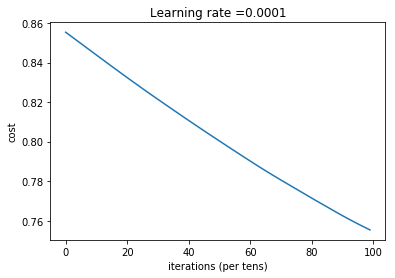

Parameters have been trained!
Train Accuracy: 0.9513309
Test Accuracy: 0.9515554


In [34]:
parameters_DNN = model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 500, minibatch_size = 522878, print_cost = True)

In [35]:
# 利用訓練過後的模型，進行預測
def predict_new(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [14, 306313])
    
    z3 = forward_propagation_for_predict_new(x, params)
    p = tf.sigmoid(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def forward_propagation_for_predict_new(X, parameters):
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

In [37]:
test_dnn = testset[predictors].copy()
test_dnn[mm_target] = mm.fit_transform(test_dnn[mm_target])
test_dnn =  test_dnn.transpose().values

dnn_pred = predict_new(test_dnn, parameters_DNN)
dnn_pred = dnn_pred.transpose()

output_06 = output.copy()
output_06['pred_prob'] = dnn_pred
out_06 = output_06.groupby("uid", as_index=False).mean()
out_06 = out_06[["uid", "pred_prob"]]
out_06.columns = ["uid", "label"]
print(out_06.head())
out_06.to_csv('DNN_1.csv',index=False)

                     uid     label
0  1000020_2705_20160519  0.084036
1  1000020_8192_20160513  0.258802
2  1000065_1455_20160527  0.259890
3  1000085_8067_20160513  0.258380
4  1000086_2418_20160613  0.144062


In [38]:
## unbias data sampling - 07
# df_04[predictors]
# mm = MinMaxScaler()
# mm_target = ['discount_man','discount_jian','Distance','weekday']

df_dnn_07 = df_04[predictors].copy()
Y_07 = df_04['label'].copy()

df_dnn_07[mm_target] = mm.fit_transform(df_dnn_07[mm_target])

X_train_07, X_test_07, Y_train_07, Y_test_07 = train_test_split(df_dnn_07, Y_07, test_size=0.4, random_state=42)

X_train_07 = X_train_07.transpose().values
X_test_07 = X_test_07.transpose().values
Y_train_07 = Y_train_07.values.reshape(1,len(Y_train_07))
Y_test_07 = Y_test_07.values.reshape(1,len(Y_test_07))
print ("X_train shape: " + str(X_train_07.shape))
print ("Y_train shape: " + str(Y_train_07.shape))
print ("X_test shape: " + str(X_test_07.shape))
print ("Y_test shape: " + str(Y_test_07.shape))

X_train shape: (14, 57782)
Y_train shape: (1, 57782)
X_test shape: (14, 38522)
Y_test shape: (1, 38522)


Cost after epoch 0: 0.745814
Cost after epoch 100: 0.683394
Cost after epoch 200: 0.679919


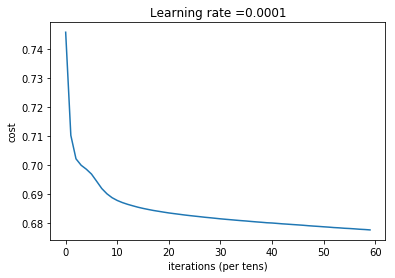

Parameters have been trained!
Train Accuracy: 0.71392477
Test Accuracy: 0.71514976


In [39]:
parameters_DNN_07 = model(X_train_07, Y_train_07, X_test_07, Y_test_07, learning_rate = 0.0001,
          num_epochs = 300, minibatch_size = 512, print_cost = True)

In [40]:
dnn_pred_07 = predict_new(test_dnn, parameters_DNN_07)
dnn_pred_07 = dnn_pred_07.transpose()

output_07 = output.copy()
output_07['pred_prob'] = dnn_pred_07
out_07 = output_07.groupby("uid", as_index=False).mean()
out_07 = out_07[["uid", "pred_prob"]]
out_07.columns = ["uid", "label"]
print(out_07.head())
out_07.to_csv('DNN_2.csv',index=False)

                     uid     label
0  1000020_2705_20160519  0.770820
1  1000020_8192_20160513  0.503599
2  1000065_1455_20160527  0.202747
3  1000085_8067_20160513  0.153011
4  1000086_2418_20160613  0.189732


In [42]:
SGD = pd.read_csv('try.csv')
blend = SGD.copy()

blend['label'] = out_07['label']*0.5 + blend['label']*0.5

blend.to_csv('try.csv',index=False)